## Investigating tipping point behaviour in the control ensemble

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path

In [4]:
csv = pd.read_csv('ARC/data/AIS_PPE_control_ensemble_WAIS.csv', index_col=0, dtype=float)
tipping_runs = [20, 34, 52, 62, 70, 74, 78, 87, 103, 114] # runs which exhibit tipping point behaviour
mask = [f'{x:03}' for x in tipping_runs]
data = csv[mask]

In [5]:
def d_dt(curve: np.array, dt: int=30) -> np.array:

    '''
    Calculates the derivative of a curve given by an array of its y-coordinates.

    inputs:
        - f: numpy array of values f(t), i.e. the y-coordinates of the curve
        - dt: the gap between time coordinates, 30 by default

    output:
        - df/dt: array giving the gradient of the curve at each point (has length N-1 for f with length N)
    '''
    
    df = np.array([curve[i+1] - curve[i] for i in range(len(curve)-1)])
    return df/dt

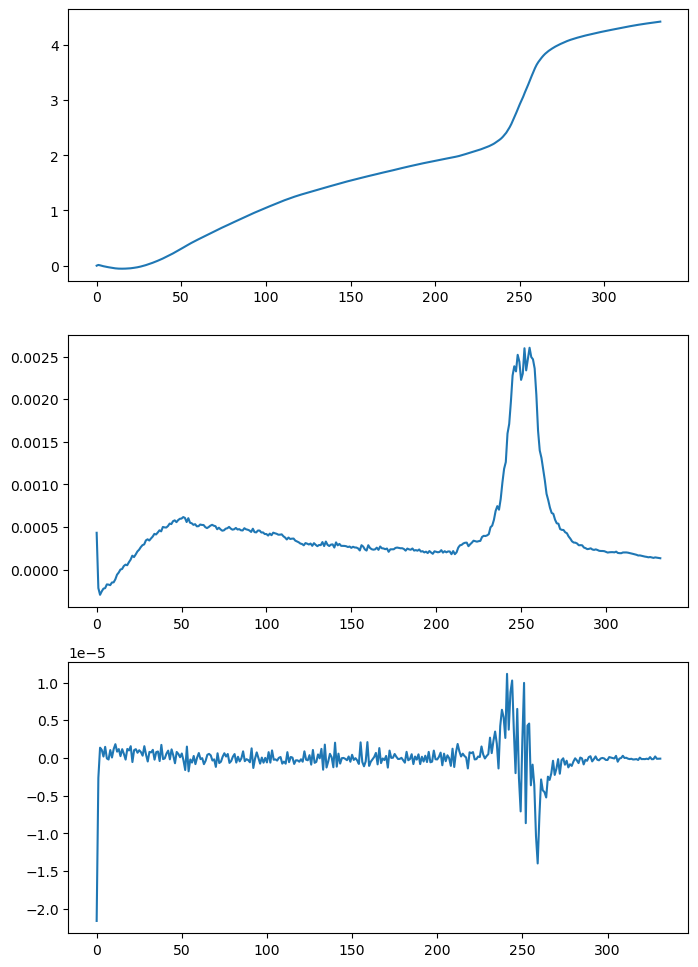

In [6]:
curve = np.array(data['020'])
derivative = d_dt(curve)
second_derivative = d_dt(derivative)
#second_derivative = d_dt(second_derivative)

fig, ax = plt.subplots(nrows=3, figsize = (8, 12))

ax[0].plot(curve)
ax[1].plot(derivative)
ax[2].plot(second_derivative)

In [7]:
def find_x_for_max_y(curve: list) -> int:

    '''
    Returns the point x at which a curve f(x) reaches its maximum value
    '''

    peak = max(curve)
    x_val = curve.index(peak)
    
    return x_val

def calculate_tipping_year(run: pd.Series) -> int:

    ''' 
    Calculates the year in which a tipping point occurs.
    '''

    curve = np.array(run)
    derivative = d_dt(curve)
    second_derivative = d_dt(derivative)

    x = find_x_for_max_y(list(second_derivative))
    tipping_year = x*30

    return tipping_year


In [8]:
# calculate tipping years for all runs

tipping_years = {}

for run_id in data.columns:
    run = data[run_id]
    year = calculate_tipping_year(run)
    tipping_years[run_id] = year

tipping_years

{'020': 7230,
 '034': 5550,
 '052': 6690,
 '062': 5880,
 '070': 5850,
 '074': 5100,
 '078': 6300,
 '087': 5550,
 '103': 6930,
 '114': 4740}

In [9]:
def load(variable: str, run: str, at_time: int) -> list[xr.DataArray]:

    '''
    Opens all netcdfs for a given variable and extracts the 2-d spatial data at a given time value. Returns
    a list of DataArrays which can then be further manipulated, e.g. to find the ensemble mean.

    inputs:
     - variable: the variable name, e.g. thickness
     - at_time: the simulation time to plot (30 for first timestep and 9990 for last timestep)

    output:
     - data: a list of xarray DataArrays, with each element being one run in the ensemble. 
    '''

    path = Path('/Users/jonniebarnsley/data/phd/Control')
    file = path / variable / f'run{run}_control_{variable}_0lev.nc'

    dataset = xr.open_dataset(file, engine='netcdf4')
    array = dataset[variable]
    array_at_time_t = array.sel(t=at_time).drop_vars('t') # select time and drop time variable from dataarray
    
    return array_at_time_t

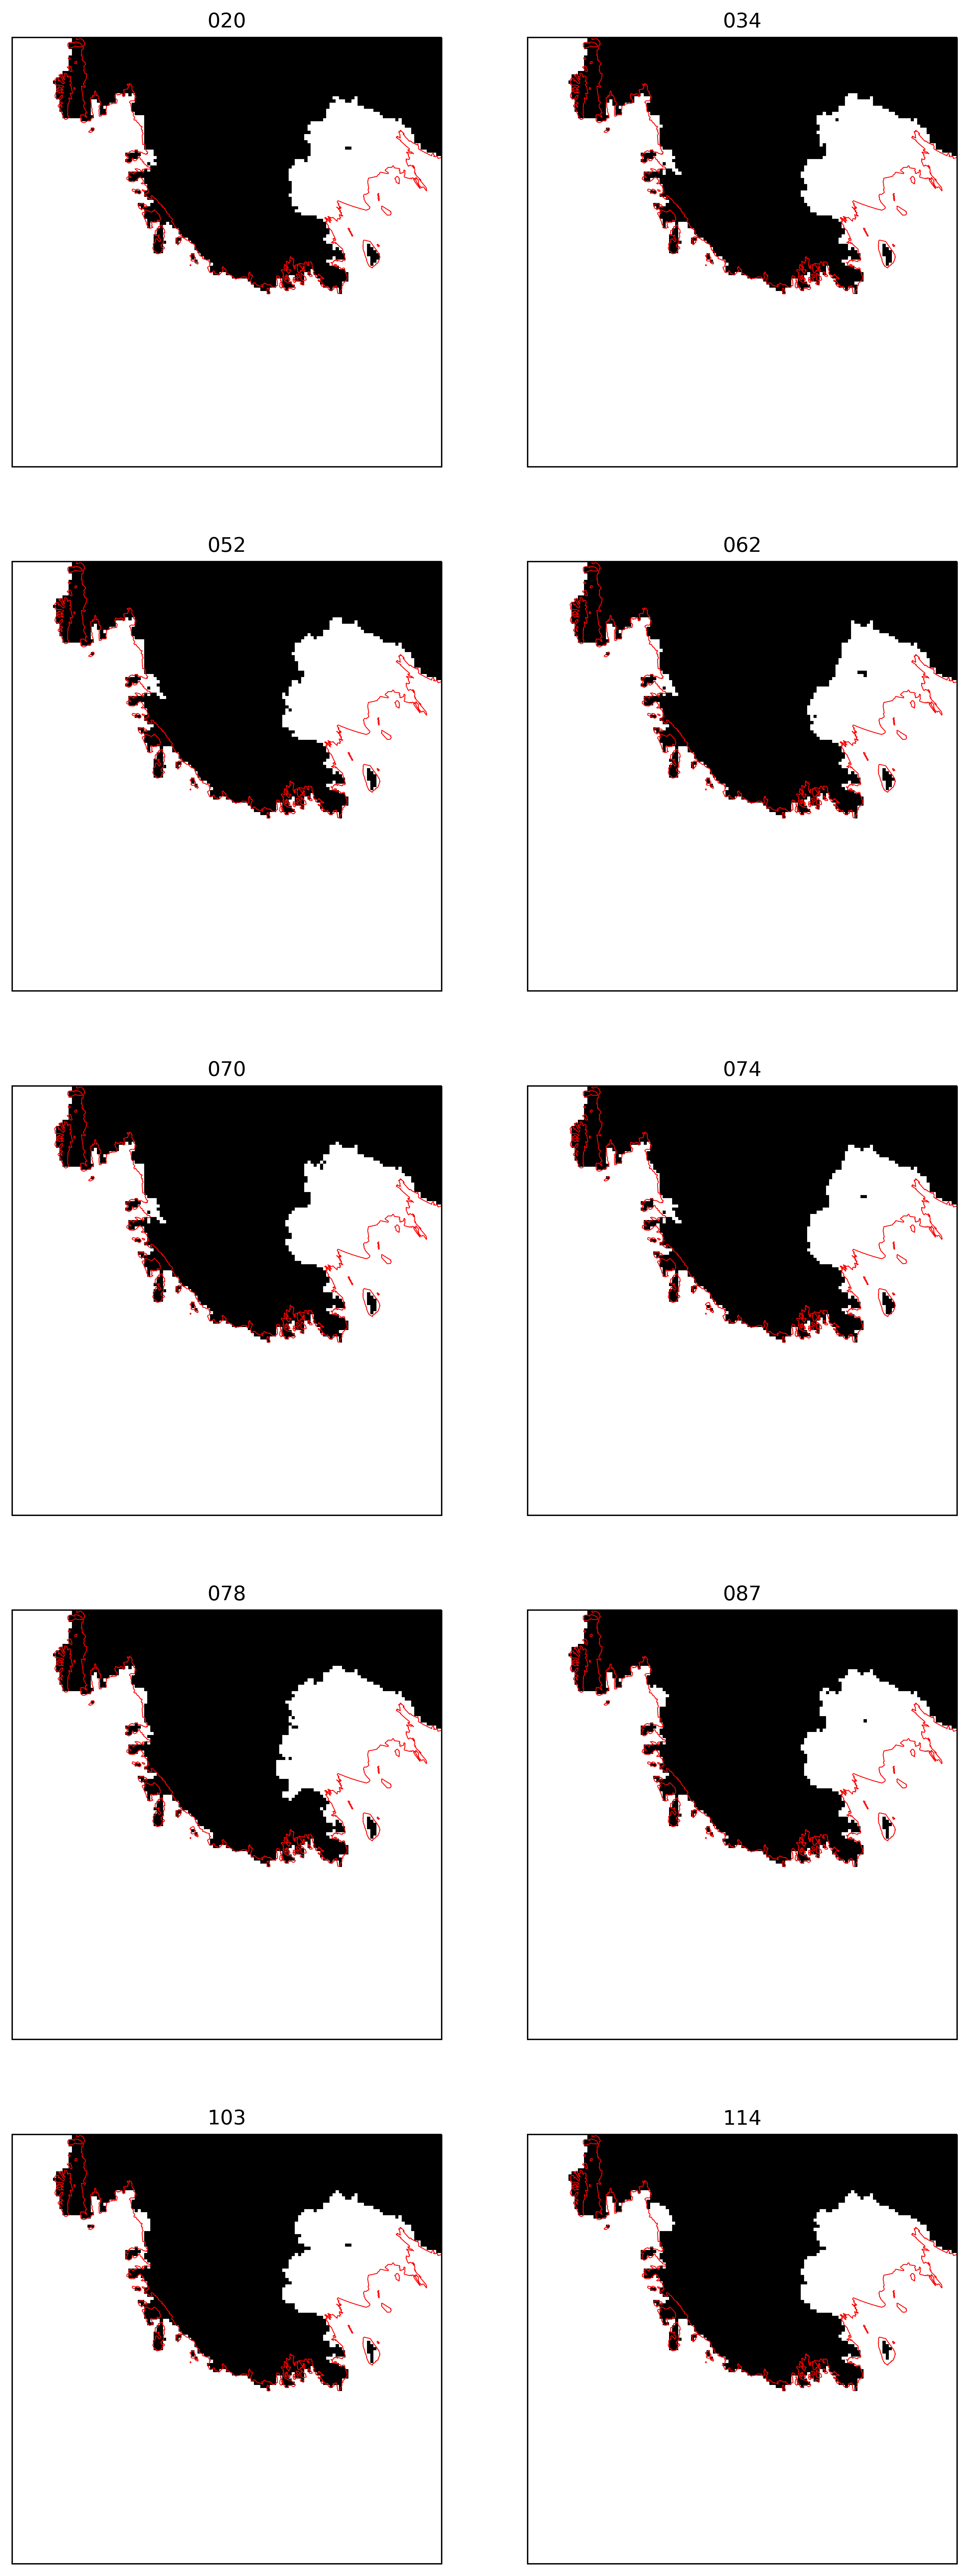

In [10]:
rhoi = 918  # density of ice
rhoo = 1028 # density of ocean

fig, axes = plt.subplots(ncols=2, nrows=5, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(10, 27), dpi=400)

for ax, num in zip(axes.flatten(), tipping_runs):

    run_id = f'{num:03}'
    time = tipping_years[run_id] - 600

    zbase = load('Z_base', run_id, time)
    thk = load('thickness', run_id, time)

    grounded = (thk > -zbase*rhoo/rhoi).astype(int)

    x = grounded.x
    y = grounded.y

    mid = max(x)/2
    xs = x - mid
    ys = y - mid

    kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
    ax.pcolormesh(xs, ys, grounded, cmap='Greys', transform=ccrs.Stereographic(**kw))
    ax.coastlines('10m', color='red', lw=0.5)
    ax.set_title(run_id)
    ax.set_extent([-180, -90, 360, -70])

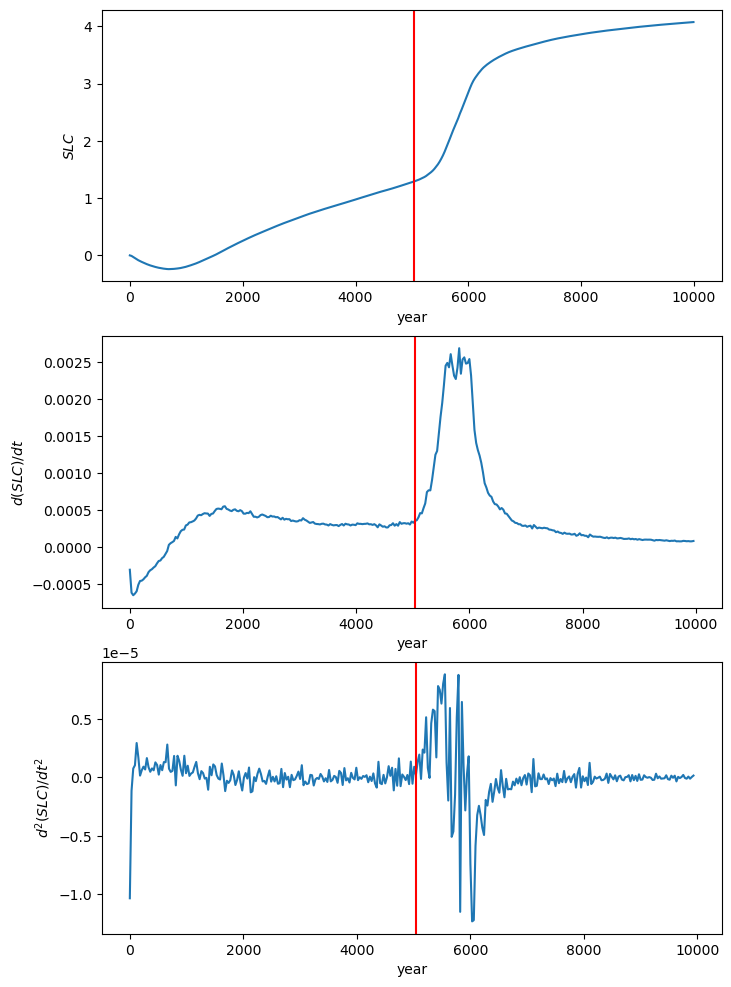

In [11]:
tipping_years['087']/30

In [12]:
run_id = '087'
run = data[run_id]
curve = np.array(run)
derivative = d_dt(curve)
second_derivative = d_dt(derivative)

year = tipping_years[run_id] - 510

fig, ax = plt.subplots(nrows=3, figsize = (8, 12))

ax[0].plot(np.arange(0, 10050, 30), curve)
ax[1].plot(np.arange(0, 10020, 30), derivative)
ax[2].plot(np.arange(0, 9990, 30), second_derivative)

ax[0].set_ylabel('$SLC$')
ax[1].set_ylabel('$d(SLC)/dt$')
ax[2].set_ylabel('$d^2(SLC)/dt^2$')


for x in ax.flatten():
    x.axvline(year, color='red')
    x.set_xlabel('year')

In [13]:
import ewstools

185.0

In [14]:
from ewstools.models import simulate_ricker
series = simulate_ricker(tmax=500, F=[0,2.7])
series

time
0       9.914271
1       9.977237
2       9.713356
3       9.929887
4      10.088563
         ...    
495     0.246045
496     0.247363
497     0.258776
498     0.230829
499     0.254370
Length: 500, dtype: float64

In [15]:
ts = ewstools.TimeSeries(data=series, transition=200)

In [16]:
ts.detrend(method='Lowess', span=0.2)
ts.compute_var(rolling_window=0.5)
ts.compute_auto(lag=1, rolling_window=0.5)
ts.compute_auto(lag=2, rolling_window=0.5)
ts.compute_ktau()

In [17]:
ts.make_plotly()

In [18]:
df = pd.DataFrame(data = {
    'curve': curve[1:-2],
    'derivative': derivative[1:-1],
    'second_derivative': second_derivative[1:]
})

In [22]:
series = df['curve']
ts = ewstools.TimeSeries(data=df['curve'], transition=175)
ts.detrend(method='Lowess', span=15)
ts.compute_var(rolling_window=10)
ts.compute_auto(lag=1, rolling_window=10)
#ts.compute_auto(lag=2, rolling_window=0.5)
ts.compute_ktau()
ts.make_plotly()